### Analyzing historical seasonal indicators
To understand Malawi's seasonal patterns a little better
Looking at 
- seasonal rainfall
- rainy season duration
- temperature anomaly

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import rioxarray

In [2]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
# print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_ftp,download_url
from src.utils_general.raster_manipulation import fix_calendar, invert_latlon, change_longitude_range
from src.utils_general.plotting import plot_raster_boundaries_clip,plot_spatial_columns

#### Set config values

In [3]:
country="malawi"
config=Config()
parameters = config.parameters(country)
country_dir = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.RAW_DIR,country)
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PROCESSED_DIR,country)
country_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration",country)
drought_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration","drought")
dry_spells_processed_dir=os.path.join(country_data_processed_dir,"dry_spells")
chirpsgefs_processed_dir = os.path.join(dry_spells_processed_dir,"chirpsgefs")

#we have different methodologies of computing dryspells and rainy season
#this notebook chooses one, which is indicated by the files being used
chirpsgefs_stats_path=os.path.join(chirpsgefs_processed_dir,"mwi_chirpsgefs_rainyseas_stats_mean_back.csv")
chirps_rolling_sum_path=os.path.join(dry_spells_processed_dir,"data_mean_values_long.csv")

adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])
adm3_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,"mwi_adm_nso_20181016_shp/mwi_admbnda_adm3_nso_20181016.shp")

private_country_data_raw_dir = os.path.join(os.environ["AA_DATA_PRIVATE_DIR"],config.RAW_DIR,country)

In [4]:
ds_meth="mean_2mm"
# ds_meth="consecutive_days_2mm"
# ds_meth="consecutive_days_4mm"

In [5]:
#we have different methodologies of computing dryspells and rainy season
#this notebook chooses one, which is indicated by the files being used
if ds_meth=="mean_2mm":
    dry_spells_list_path=os.path.join(dry_spells_processed_dir,f"dry_spells_during_rainy_season_list_2000_2020_mean_back.csv")
elif ds_meth=="consecutive_days_2mm":
    dry_spells_list_path=os.path.join(dry_spells_processed_dir,f"daily_mean_dry_spells_details_2mm_2000_2020.csv")
elif ds_meth=="consecutive_days_4mm":
    dry_spells_list_path=os.path.join(dry_spells_processed_dir,f"daily_mean_dry_spells_details_2000_2020.csv")

#### Load data on rainy season duration and total rainfall

In [6]:
#path to data start and end rainy season
df_rain=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","rainy_seasons_detail_2000_2020_mean.csv"))
df_rain["onset_date"]=pd.to_datetime(df_rain["onset_date"])
df_rain["cessation_date"]=pd.to_datetime(df_rain["cessation_date"])

In [7]:
#suspecting that "year" in wfp data refers to the second half of the rainy season, i.e. year=2016 is Nov 2015 till Apr 2016. Season_approx is the other way around, i.e. season_approx=2015 is Nov 2015 till Apr 2016
df_rain["season_approx_wfp"]=df_rain.season_approx+1

#### Retrieve data on temperature anomaly

In [8]:
cams_temp_path=os.path.join(drought_data_exploration_dir,"CAMS_OPI","temperature","cams_temp_anomaly_20002020.nc")

In [9]:
temp_ds=xr.open_dataset(cams_temp_path,decode_times=False)
temp_ds=temp_ds.rename({"X":"lon","Y":"lat"})
temp_ds=fix_calendar(temp_ds,timevar="T")
temp_ds = xr.decode_cf(temp_ds)
temp_ds = invert_latlon(temp_ds)

In [10]:
temp_ds

<xarray.Dataset>
Dimensions:  (T: 258, lat: 90, lon: 180)
Coordinates:
  * lat      (lat) float64 89.0 87.0 85.0 83.0 81.0 ... -83.0 -85.0 -87.0 -89.0
  * lon      (lon) float32 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * T        (T) object 1999-10-16 00:00:00 ... 2021-03-16 00:00:00
Data variables:
    temp     (T, lat, lon) float32 ...

In [11]:
temp_ds_sel=temp_ds.sel(T=temp_ds.T.dt.month.isin([11,12,1,2,3,4]))

In [12]:
def alldates_statistics_total(ds,raster_transform,adm_path):
    #compute statistics on level in adm_path for all dates in ds
    df_list=[]
    for date in ds.T.values:
        df=gpd.read_file(adm_path)
        ds_date=ds.sel(T=date)
        
        
        df["mean_cell"] = pd.DataFrame(
        zonal_stats(vectors=df, raster=ds_date["temp"].values, affine=raster_transform, nodata=np.nan,all_touched=True))["mean"]
        
        df["date"]=pd.to_datetime(date.strftime("%Y-%m-%d"))
  
        df_list.append(df)
    df_hist=pd.concat(df_list)
    df_hist=df_hist.sort_values(by="date")
    
    df_hist["date_str"]=df_hist["date"].dt.strftime("%Y-%m")
    df_hist['date_month']=df_hist.date.dt.to_period("M")
        
    return df_hist

In [13]:
df_temp=alldates_statistics_total(temp_ds_sel,temp_ds_sel.rio.write_crs("EPSG:4326").rio.transform(),adm2_bound_path)

In [14]:
#very little occurences of negative anomalies..
#might be cause based on 1971-2000 climatology?
df_bound=gpd.read_file(adm1_bound_path)
ds_clip = temp_ds_sel.rio.write_crs("EPSG:4326").rio.clip(df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)
np.unique(ds_clip.temp.values.flatten()[~np.isnan(ds_clip.temp.values.flatten())])

array([-1.5, -1.1, -1. , -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,
        0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,
        1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,
        2.4], dtype=float32)

In [15]:
df_temp[df_temp.mean_cell<0].date_month.unique()

<PeriodArray>
['2002-11', '2008-03', '2008-04', '2009-04', '2012-04']
Length: 5, dtype: period[M]

In [16]:
df_temp.groupby("mean_cell").count()

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry,date_str,date_month
mean_cell,,,,,,,,,,,,,,,,,
-1.500000,1,1,1,1,0,0,0,1,1,1,1,1,1,0,1,1,1
-1.250000,5,5,5,5,0,0,0,5,5,5,5,5,5,0,5,5,5
-1.050000,2,2,2,2,0,0,0,2,2,2,2,2,2,0,2,2,2
-1.033333,1,1,1,1,0,0,0,1,1,1,1,1,1,0,1,1,1
-1.025000,1,1,1,1,0,0,0,1,1,1,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.275000,2,2,2,2,0,0,0,2,2,2,2,2,2,0,2,2,2
2.300000,1,1,1,1,0,0,0,1,1,1,1,1,1,0,1,1,1
2.300000,5,5,5,5,0,0,0,5,5,5,5,5,5,0,5,5,5


In [17]:
df_temp["season_approx"]=np.where(df_temp.date_month.dt.month>=9,df_temp.date_month.dt.year,df_temp.date_month.dt.year-1)
df_temp["season_approx_wfp"]=df_temp.season_approx+1

In [18]:
df_temp_raindates=df_temp.merge(df_rain[["season_approx","ADM2_EN","onset_date","cessation_date"]],on=["season_approx","ADM2_EN"],how="left")

In [19]:
df_temp_rain=df_temp_raindates[(df_temp_raindates.date>=df_temp_raindates.onset_date)&(df_temp_raindates.date<=df_temp_raindates.cessation_date)]

In [20]:
df_temp_rain_seas=df_temp_rain.groupby(["ADM2_EN","season_approx"],as_index=False).mean()

### Plot the three seasonal indicators from 2000 till 2019

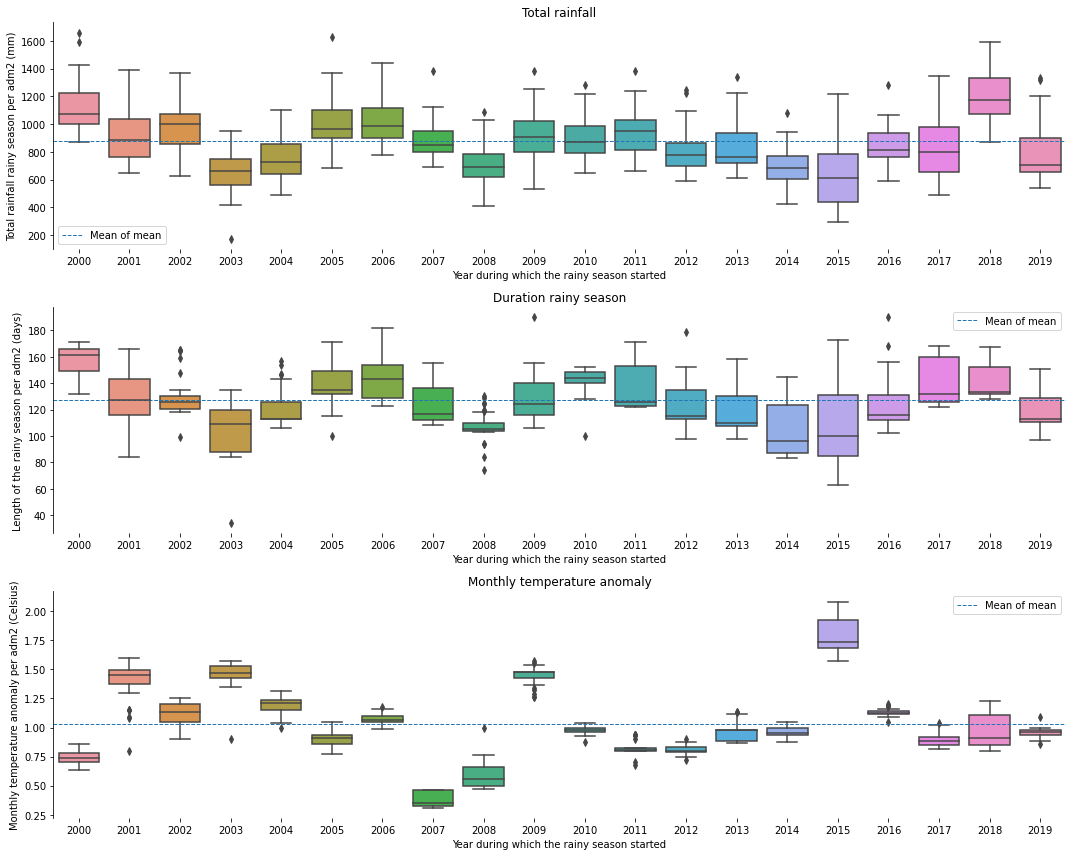

In [21]:
# df_rain.groupby("season_approx",as_index=False).mean().plot(x="season_approx",y="rainy_season_duration")
fig, axes = plt.subplots(3,1,figsize=(15,12))
sns.boxplot(x="season_approx", y="rainy_season_rainfall", data=df_rain[df_rain.season_approx.isin(range(2000,2020))],ax=axes.flatten()[0])
axes.flatten()[0].axhline(y=df_rain[df_rain.season_approx.isin(range(2000,2020))].groupby("season_approx",as_index=False).mean().rainy_season_rainfall.mean(), linestyle='--', linewidth=1, label='Mean of mean')
# plt.legend()
axes.flatten()[0].set_title("Total rainfall")
axes.flatten()[0].set_ylabel("Total rainfall rainy season per adm2 (mm)")
sns.boxplot(x="season_approx", y="rainy_season_duration", data=df_rain[df_rain.season_approx.isin(range(2000,2020))],ax=axes.flatten()[1])
axes.flatten()[1].axhline(y=df_rain[df_rain.season_approx.isin(range(2000,2020))].groupby("season_approx",as_index=False).mean().rainy_season_duration.mean(), linestyle='--', linewidth=1, label='Mean of mean')
axes.flatten()[1].set_ylabel("Length of the rainy season per adm2 (days)")
axes.flatten()[1].set_title("Duration rainy season")
sns.boxplot(x="season_approx", y="mean_cell", data=df_temp_rain_seas[df_temp_rain_seas.season_approx.isin(range(2000,2020))],ax=axes.flatten()[2])

axes.flatten()[2].set_title("Monthly temperature anomaly")
axes.flatten()[2].axhline(y=df_temp_rain_seas[df_temp_rain_seas.season_approx.isin(range(2000,2020))].groupby("season_approx",as_index=False).mean().mean_cell.mean(), linestyle='--', linewidth=1, label='Mean of mean')
axes.flatten()[2].set_ylabel("Monthly temperature anomaly per adm2 (Celsius)")

sns.despine(bottom=True) # removes right and top axis lines
for ax in axes.flatten():
    ax.set_xlabel("Year during which the rainy season started")
    ax.legend()
fig.tight_layout()